In [1]:
from matplotlib import image
from matplotlib import pyplot
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection

DataPreProcessing:

0 1 2 3 4 5 6 7 8 9 a b c d e f g h i j k l m n o p q r s t u v w x y z uint8 (400, 400, 3)
(2515, 400, 400, 3) (2515,) 36
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


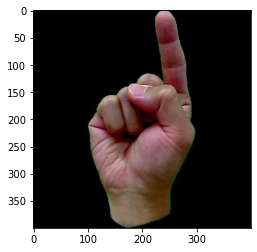

In [2]:
path = './asl_dataset/'
data,rawLabel = [],[]
labelTypes=[]
for root, dirs, files in os.walk(path):
    key = os.path.basename(root)
    if key=="": continue
    labelTypes.append(key)
    print(key, end=' ')
    for file in files:
        full_file_path = os.path.join(root,file)
        img = image.imread(full_file_path)
        data.append(img)
        rawLabel.append(key)

data = np.array(data)/255.0
rawLabel = np.array(rawLabel)
labelNum=len(labelTypes)
print(img.dtype,img.shape)
pyplot.imshow(img)
print(data.shape,rawLabel.shape,labelNum)
print(labelTypes)

In [3]:
label=np.array([[rawLabel[i]==labelTypes[j] for j in range(labelNum)]for i in range(len(rawLabel))]).astype('f4')
print(label.shape)
print(label[0])
print(label[-1])

(2515, 36)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


#split data into train and test for cross validation

In [4]:
X_train,X_use,y_train,y_use  = model_selection.train_test_split(data, label, train_size=0.8, shuffle=True)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_use, y_use, train_size=0.5, shuffle=True)
print(X_train.shape, X_test.shape,X_val.shape, y_train.shape, y_test.shape,y_val.shape)

(2012, 400, 400, 3) (251, 400, 400, 3) (252, 400, 400, 3) (2012, 36) (251, 36) (252, 36)


In [5]:
X_trainTensor=tf.constant(X_train)
X_testTensor=tf.constant(X_test)
X_valTensor=tf.constant(X_val)
Y_trainTensor=tf.constant(y_train)
Y_testTensor=tf.constant(y_test)
Y_valTensor=tf.constant(y_val)
print(X_trainTensor.shape,Y_trainTensor.shape)

(2012, 400, 400, 3) (2012, 36)


Data Analysis:

By observing the following histgram, 

we find that each type of images are almost the same amount(70).

By looking through each data type folder, 

we find that the qulities of each type of data is presistent.

(array([70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70., 70., 70., 65., 70., 70., 70., 70., 70., 70.]),
 array([ 0.        ,  0.97222222,  1.94444444,  2.91666667,  3.88888889,
         4.86111111,  5.83333333,  6.80555556,  7.77777778,  8.75      ,
         9.72222222, 10.69444444, 11.66666667, 12.63888889, 13.61111111,
        14.58333333, 15.55555556, 16.52777778, 17.5       , 18.47222222,
        19.44444444, 20.41666667, 21.38888889, 22.36111111, 23.33333333,
        24.30555556, 25.27777778, 26.25      , 27.22222222, 28.19444444,
        29.16666667, 30.13888889, 31.11111111, 32.08333333, 33.05555556,
        34.02777778, 35.        ]),
 <BarContainer object of 36 artists>)

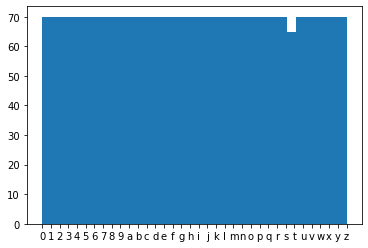

In [6]:
pyplot.hist(rawLabel,bins=labelNum)

two-Channel-AutoEncoders:

Here we'll build 3 different two-Channel-AutoEncoders which encode original 400*400*3 graphs into:

1) 40*40*1

2) 10*10*1

3) 5*5*1

In [7]:
class AutoEncoder1(keras.Model):
  def __init__(self):
    super(AutoEncoder1, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.Conv2D(2, (5,5), activation = 'relu',strides=1,padding='same'),
      layers.MaxPool2D(pool_size=(5, 5),strides=(5, 5), padding='same'),
      layers.Conv2D(4, (3,3), activation = 'relu',strides=1,padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(2, (3,3), activation = 'sigmoid',strides=1,padding='same')
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(2,(5,5),strides=5,activation='relu', padding='same'),
      layers.Conv2DTranspose(16,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder1=AutoEncoder1()
autoencoder1.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history1 = autoencoder1.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Epoch 1/30
63/63 [==============================] - 185s 3s/step - loss: 0.1062 - val_loss: 0.0597
Epoch 2/30
63/63 [==============================] - 181s 3s/step - loss: 0.0572 - val_loss: 0.0486
Epoch 3/30
63/63 [==============================] - 183s 3s/step - loss: 0.0354 - val_loss: 0.0180
Epoch 4/30
63/63 [==============================] - 183s 3s/step - loss: 0.0149 - val_loss: 0.0116
Epoch 5/30
63/63 [==============================] - 180s 3s/step - loss: 0.0098 - val_loss: 0.0074
Epoch 6/30
63/63 [==============================] - 180s 3s/step - loss: 0.0066 - val_loss: 0.0058
Epoch 7/30
63/63 [==============================] - 182s 3s/step - loss: 0.0055 - val_loss: 0.0050
Epoch 8/30
63/63 [==============================] - 179s 3s/step - loss: 0.0050 - val_loss: 0.0046
Epoch 9/30
63/63 [==============================] - 182s 3s/step - loss: 0.0046 - val_loss: 0.0044
Epoch 10/30
63/63 [==============================] - 181s 3s/step - loss: 0.0044 - val_loss: 0.0041
Epoch 11/

In [8]:
autoencoder1.summary()

Model: "auto_encoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 40, 40, 2)         302       
                                                                 
 sequential_1 (Sequential)   (None, 400, 400, 3)       3161      
                                                                 
Total params: 3,463
Trainable params: 3,463
Non-trainable params: 0
_________________________________________________________________


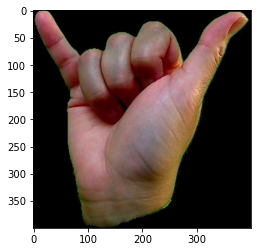

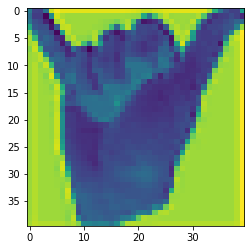

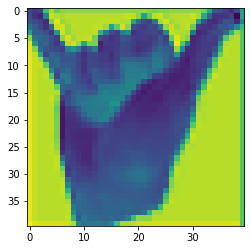

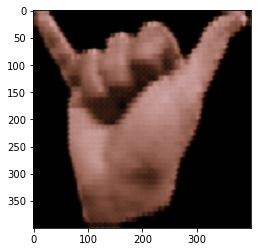

In [9]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=autoencoder1.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy()[:,:,0]);
pyplot.show()
pyplot.imshow(middleImage[0].numpy()[:,:,1]);
pyplot.show()
newImage=autoencoder1.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

In [10]:
class AutoEncoder2(keras.Model):
  def __init__(self):
    super(AutoEncoder2, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(10, 10),strides=(10, 10), padding='same'),
      layers.Conv2D(4, (3,3),strides=1,activation='relu', padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(2, (3,3),strides=1,activation="sigmoid",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(2,(5,5),strides=5,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(8,(5,5),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(16,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(32,(3,3),strides=1,activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder2=AutoEncoder2()
autoencoder2.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history2 = autoencoder2.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Epoch 1/30
63/63 [==============================] - 499s 8s/step - loss: 0.0476 - val_loss: 0.0868
Epoch 2/30
63/63 [==============================] - 489s 8s/step - loss: 0.0181 - val_loss: 0.0869
Epoch 3/30
63/63 [==============================] - 482s 8s/step - loss: 0.0153 - val_loss: 0.0847
Epoch 4/30
63/63 [==============================] - 483s 8s/step - loss: 0.0139 - val_loss: 0.0816
Epoch 5/30
63/63 [==============================] - 481s 8s/step - loss: 0.0129 - val_loss: 0.0750
Epoch 6/30
63/63 [==============================] - 482s 8s/step - loss: 0.0123 - val_loss: 0.0687
Epoch 7/30
63/63 [==============================] - 482s 8s/step - loss: 0.0119 - val_loss: 0.0575
Epoch 8/30
63/63 [==============================] - 481s 8s/step - loss: 0.0116 - val_loss: 0.0533
Epoch 9/30
63/63 [==============================] - 473s 8s/step - loss: 0.0114 - val_loss: 0.0382
Epoch 10/30
63/63 [==============================] - 473s 8s/step - loss: 0.0113 - val_loss: 0.0262
Epoch 11/

In [11]:
autoencoder2.summary()

Model: "auto_encoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 10, 10, 2)         186       
                                                                 
 sequential_3 (Sequential)   (None, 400, 400, 3)       7821      
                                                                 
Total params: 8,007
Trainable params: 7,991
Non-trainable params: 16
_________________________________________________________________


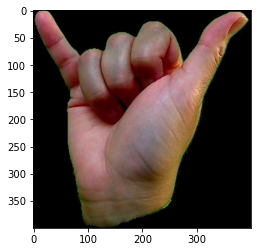

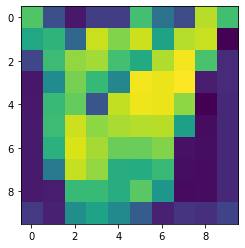

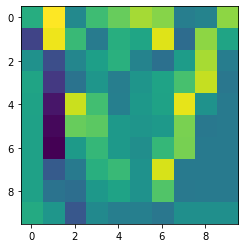

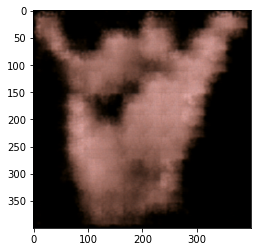

In [12]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=autoencoder2.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy()[:,:,0]);
pyplot.show()
pyplot.imshow(middleImage[0].numpy()[:,:,1]);
pyplot.show()
newImage=autoencoder2.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

In [13]:
class AutoEncoder3(keras.Model):
  def __init__(self):
    super(AutoEncoder3, self).__init__()
    self.encoder = tf.keras.models.Sequential([
      layers.MaxPool2D(pool_size=(10, 10),strides=(10, 10), padding='same'),
      layers.Conv2D(4, (3,3),strides=1,activation='relu', padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(2, (3,3),strides=1,activation="relu",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      layers.Conv2D(2, (3,3),strides=1,activation="sigmoid",padding='same'),
      layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
      ])
    self.decoder = tf.keras.models.Sequential([
      layers.Conv2DTranspose(2,(5,5),strides=5,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(4,(5,5),strides=2,activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(16,(3,3),strides=2,activation='relu', padding='same'),
      layers.Conv2DTranspose(32,(3,3),strides=1,activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder3=AutoEncoder3()
autoencoder3.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())
history3 = autoencoder3.fit(X_trainTensor, X_trainTensor, 
                          validation_data=(X_valTensor,X_valTensor), 
                          epochs=30,shuffle=True)

Epoch 1/30
63/63 [==============================] - 275s 4s/step - loss: 0.1011 - val_loss: 0.0734
Epoch 2/30
63/63 [==============================] - 274s 4s/step - loss: 0.0622 - val_loss: 0.0673
Epoch 3/30
63/63 [==============================] - 274s 4s/step - loss: 0.0513 - val_loss: 0.0533
Epoch 4/30
63/63 [==============================] - 274s 4s/step - loss: 0.0304 - val_loss: 0.0457
Epoch 5/30
63/63 [==============================] - 273s 4s/step - loss: 0.0258 - val_loss: 0.0361
Epoch 6/30
63/63 [==============================] - 274s 4s/step - loss: 0.0239 - val_loss: 0.0296
Epoch 7/30
63/63 [==============================] - 274s 4s/step - loss: 0.0231 - val_loss: 0.0255
Epoch 8/30
63/63 [==============================] - 274s 4s/step - loss: 0.0226 - val_loss: 0.0243
Epoch 9/30
63/63 [==============================] - 274s 4s/step - loss: 0.0223 - val_loss: 0.0230
Epoch 10/30
63/63 [==============================] - 273s 4s/step - loss: 0.0220 - val_loss: 0.0215
Epoch 11/

In [14]:
autoencoder3.summary()

Model: "auto_encoder3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 5, 5, 2)           224       
                                                                 
 sequential_5 (Sequential)   (None, 400, 400, 3)       7697      
                                                                 
Total params: 7,921
Trainable params: 7,913
Non-trainable params: 8
_________________________________________________________________


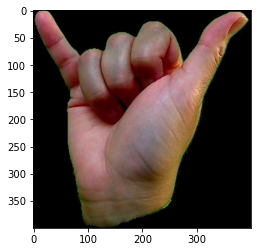

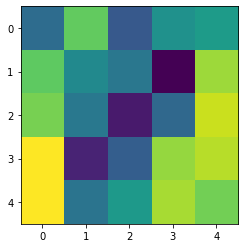

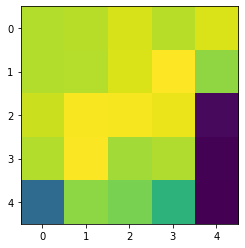

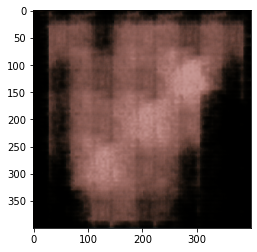

In [15]:
pyplot.imshow(X_train[0]);
pyplot.show()
middleImage=autoencoder3.encoder(X_train[[0]])
pyplot.imshow(middleImage[0].numpy()[:,:,0]);
pyplot.show()
pyplot.imshow(middleImage[0].numpy()[:,:,1]);
pyplot.show()
newImage=autoencoder3.decoder(middleImage)[0].numpy()
pyplot.imshow(newImage);

summary:

Classifiers:
now we'll build 3 different classifiers based on different AutoEncoders with slightly different structure.

In [52]:
class Clasiffier1(keras.Model):
  def __init__(self):
    super(Clasiffier1, self).__init__()
    self.linear = tf.keras.models.Sequential([
        layers.Conv2D(32, (5,5), activation = 'relu',strides=1,padding='valid'),
        layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        #layers.BatchNormalization(),
        layers.Conv2D(64, (5,5), activation = 'relu',strides=1,padding='valid'),
        #layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        layers.Flatten(),
        #layers.BatchNormalization(),
        layers.Dense(128,activation='relu'),
        layers.Dense(36,activation='softmax')
      ])

  def call(self, x):
    encoded = autoencoder1.encoder(x)
    return self.linear(encoded)
  
clasiffier1=Clasiffier1()

class Clasiffier2(keras.Model):
    def __init__(self):
      super(Clasiffier2, self).__init__()
      self.linear = tf.keras.models.Sequential([
        layers.Conv2D(16, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (5,5), activation = 'relu',strides=1,padding='valid'),
        layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

    def call(self, x):
      encoded = autoencoder2.encoder(x)
      return self.linear(encoded)
  
clasiffier2=Clasiffier2()

class Clasiffier3(keras.Model):
    def __init__(self):
      super(Clasiffier3, self).__init__()
      self.linear = tf.keras.models.Sequential([
        layers.Conv2D(16, (5,5), activation = 'relu',strides=1,padding='same'),
        layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (5,5), activation = 'relu',strides=1,padding='valid'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(36,activation='softmax')
      ])

    def call(self, x):
      encoded = autoencoder3.encoder(x)
      return self.linear(encoded)
  
clasiffier3=Clasiffier3()

In [53]:
clasiffier1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history4 = clasiffier1.fit(X_trainTensor, Y_trainTensor, epochs=100,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

Epoch 1/100
63/63 [==============================] - 10s 138ms/step - loss: 2.8986 - accuracy: 0.2048 - val_loss: 1.6415 - val_accuracy: 0.5476
Epoch 2/100
63/63 [==============================] - 8s 132ms/step - loss: 1.0702 - accuracy: 0.6600 - val_loss: 0.9468 - val_accuracy: 0.6984
Epoch 3/100
63/63 [==============================] - 8s 134ms/step - loss: 0.6675 - accuracy: 0.7793 - val_loss: 0.6998 - val_accuracy: 0.7857
Epoch 4/100
63/63 [==============================] - 8s 133ms/step - loss: 0.4989 - accuracy: 0.8345 - val_loss: 0.5089 - val_accuracy: 0.8571
Epoch 5/100
63/63 [==============================] - 8s 130ms/step - loss: 0.3823 - accuracy: 0.8857 - val_loss: 0.5762 - val_accuracy: 0.8135
Epoch 6/100
63/63 [==============================] - 8s 129ms/step - loss: 0.3125 - accuracy: 0.8966 - val_loss: 0.5359 - val_accuracy: 0.8611
Epoch 7/100
63/63 [==============================] - 8s 130ms/step - loss: 0.2732 - accuracy: 0.9095 - val_loss: 0.4448 - val_accuracy: 0.877

KeyboardInterrupt: 

In [40]:
clasiffier1.summary()

Model: "clasiffier1_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 36)                45748     
                                                                 
Total params: 45,748
Trainable params: 44,116
Non-trainable params: 1,632
_________________________________________________________________


In [41]:
clasiffier2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history5 = clasiffier2.fit(X_trainTensor, Y_trainTensor, epochs=100,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

Epoch 1/100


63/63 [==============================] - 4s 43ms/step - loss: 1.7288 - accuracy: 0.5457 - val_loss: 3.5010 - val_accuracy: 0.1190
Epoch 2/100
63/63 [==============================] - 3s 40ms/step - loss: 0.5972 - accuracy: 0.8613 - val_loss: 3.5072 - val_accuracy: 0.0873
Epoch 3/100
63/63 [==============================] - 3s 41ms/step - loss: 0.3701 - accuracy: 0.9115 - val_loss: 3.6092 - val_accuracy: 0.0952
Epoch 4/100
63/63 [==============================] - 3s 41ms/step - loss: 0.2579 - accuracy: 0.9394 - val_loss: 3.6297 - val_accuracy: 0.1230
Epoch 5/100
63/63 [==============================] - 3s 40ms/step - loss: 0.2011 - accuracy: 0.9568 - val_loss: 3.3510 - val_accuracy: 0.1508
Epoch 6/100
63/63 [==============================] - 3s 41ms/step - loss: 0.1376 - accuracy: 0.9727 - val_loss: 2.7529 - val_accuracy: 0.2778
Epoch 7/100
63/63 [==============================] - 3s 40ms/step - loss: 0.1148 - accuracy: 0.9766 - val_loss: 1.8702 - val_accuracy: 0.4802
Epoch 8/100
63/63 

In [42]:
clasiffier2.summary()

Model: "clasiffier2_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 36)                25268     
                                                                 
Total params: 25,268
Trainable params: 24,660
Non-trainable params: 608
_________________________________________________________________


In [43]:
clasiffier3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history6 = clasiffier3.fit(X_trainTensor, Y_trainTensor, epochs=100,
                          validation_data=(X_valTensor,Y_valTensor),shuffle=True)

Epoch 1/100
63/63 [==============================] - 3s 28ms/step - loss: 1.8439 - accuracy: 0.5219 - val_loss: 3.5012 - val_accuracy: 0.0317
Epoch 2/100
63/63 [==============================] - 2s 27ms/step - loss: 0.7895 - accuracy: 0.7962 - val_loss: 3.4119 - val_accuracy: 0.0198
Epoch 3/100
63/63 [==============================] - 2s 27ms/step - loss: 0.5267 - accuracy: 0.8579 - val_loss: 3.3344 - val_accuracy: 0.0198
Epoch 4/100
63/63 [==============================] - 2s 27ms/step - loss: 0.4586 - accuracy: 0.8688 - val_loss: 3.1986 - val_accuracy: 0.0833
Epoch 5/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3675 - accuracy: 0.9006 - val_loss: 2.9189 - val_accuracy: 0.1230
Epoch 6/100
63/63 [==============================] - 2s 27ms/step - loss: 0.3172 - accuracy: 0.9140 - val_loss: 2.2426 - val_accuracy: 0.4206
Epoch 7/100
63/63 [==============================] - 2s 27ms/step - loss: 0.2724 - accuracy: 0.9200 - val_loss: 1.8338 - val_accuracy: 0.4841
Epoch 

KeyboardInterrupt: 

In [ ]:
clasiffier3.summary()

Model: "clasiffier3_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 36)                129060    
                                                                 
Total params: 129,060
Trainable params: 127,780
Non-trainable params: 1,280
_________________________________________________________________


note:
We see that all of them beats 90% accuracy; however none of them excess 99% during the validation

summary: